# Inverse Problem: recovering permeability filed from sparse, noisy observation

## (1) Prepare data

a shape: torch.Size([1, 841, 1])
u shape: torch.Size([1, 841, 1])
u_noise shape: torch.Size([1, 841, 1])
x shape: torch.Size([1, 841, 2])


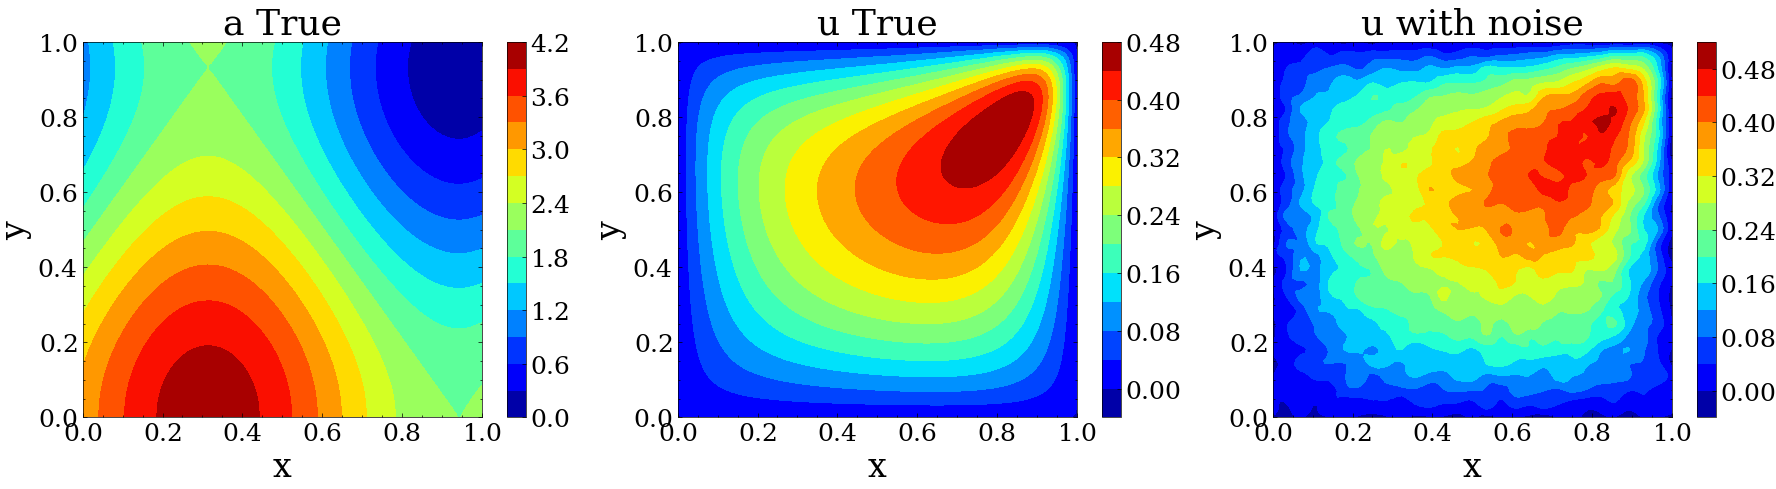

In [1]:
import sys 
sys.path.append("..") 
import numpy as np
import h5py 
import torch 
import random
import matplotlib.pyplot as plt
def setup_seed(seed):
     torch.manual_seed(seed)
     torch.cuda.manual_seed_all(seed)
     np.random.seed(seed)
     random.seed(seed)
     torch.backends.cudnn.deterministic = True
random_seed = 1234
setup_seed(random_seed)
device = 'cpu'
dtype = torch.float32
noise_level = 'SNR25'

######################################
# Load training data
######################################
data = h5py.File('dataset/smh_inverse_coe.mat', 'r')
######################################
from Utils.utils import *
def get_data(data, dtype):
    gridx = np2tensor(np.array(data["x"]), dtype)
    a = np2tensor(np.array(data["a"]), dtype)
    u = np2tensor(np.array(data["u"]), dtype)
    index_obs = np.array(data["index_obs"])
    ##########################
    sig_avg_watts = torch.mean(u**2)
    #
    if noise_level=='SNR20':
        scale = np.sqrt(sig_avg_watts/10**(20/10))
        u_noise = u + torch.randn_like(u) * scale
    elif noise_level=='SNR25':
        scale = np.sqrt(sig_avg_watts/10**(25/10))
        u_noise = u + torch.randn_like(u) * scale
    elif noise_level=='SNR50':
        scale = np.sqrt(sig_avg_watts/10**(50/10))
        u_noise = u + torch.randn_like(u) * scale
    elif noise_level=='SNR100':
        scale = np.sqrt(sig_avg_watts/10**(100/10))
        u_noise = u + torch.randn_like(u) * scale
        
    return a.unsqueeze(0), u.unsqueeze(0), u_noise.unsqueeze(0), gridx, index_obs
#
a_true, u_true, u_noise, gridx, inx_obs = get_data(data, dtype)
x = gridx.unsqueeze(0)
print('a shape:', a_true.shape)
print('u shape:', u_true.shape)
print('u_noise shape:', u_noise.shape)
print('x shape:', x.shape)
########################################
from Utils.PlotFigure import Plot
Plot.show_2d_list([gridx]*3, [a_true, u_true, u_noise], ['a True', 'u True', 'u with noise'], lb =0.)

## (2) Define the loss class

In [2]:
###############################
# Define Loss Class
###############################
import torch.nn as nn
from torch.autograd import grad, Variable
from Utils.TestFun_ParticleWNN import TestFun_ParticleWNN
#####
from Utils.GenPoints import Point2D
pointGen = Point2D(x_lb=[0., 0.], x_ub=[1.,1.], dataType=dtype, random_seed=random_seed)
##### The test function
int_grid, v, dv_dr = TestFun_ParticleWNN(
    fun_type='Wendland', dim=2, n_mesh_or_grid=7, dataType=dtype).get_testFun()
print('int_grid shape:', int_grid.shape, 'v shape:', v.shape)

###############################
class mollifer(object):

    def __inint__(self):
        super(mollifer, self).__init_()
        
    def __call__(self, u, x):
        u = u * torch.sin(np.pi * x[...,0])*torch.sin(np.pi * x[...,1])
        
        return u.unsqueeze(-1)
        
################################
class LossClass(object):

    def __init__(self, solver):
        super(LossClass, self).__init__()
        ''' '''
        self.solver = solver
        self.dtype = solver.dtype
        self.device = solver.device
        self.mollifer = mollifer()
        self.model_u = model_trained['u']
        self.model_a = model_trained['a']
        self.model_beta = solver.model_dict['beta_inv']
        self.ones = torch.ones((1,1,1)).to(device)
        #######################
        self.n_grid = int_grid.shape[0]
        self.int_grid = int_grid.to(self.device)
        self.v = v.to(self.device)
        self.dv_dr = dv_dr.to(self.device)
        #
        self.inx_obs = inx_obs

    def Loss_pde(self, a_batch, nc=100):
        ''' 
        Input:
            a_batch: size(n_batch, n_mesh, 1)
        '''
        beta = self.model_beta(self.ones)
        n_batch = a_batch.shape[0]
        ############### Data points ###############
        # xc:size(nc, 1, 2) R:size(nc, 1, 1)
        xc, R = pointGen.weight_centers(n_center=nc, R_max=1e-4, R_min=1e-4)
        xc, R = xc.to(self.device), R.to(self.device)
        # size(nc, n_grid, 2)
        x = self.int_grid * R + xc
        # size(nc*n_grid, 2) -> (n_batch, nc*n_grid, 2)
        x = x.reshape(-1, 2).repeat((n_batch,1,1))
        x = Variable(x, requires_grad=True)
        ############### Test functions #############
        v = self.v.repeat((nc,1,1)).reshape(-1,1)
        dv = (self.dv_dr / R).reshape(-1, 2)
        ################ model prediction ###########
        a_detach = self.model_a(x.detach(), beta)
        a_detach = a_detach.unsqueeze(-1)
        # u: size(n_batch, nc*n_grid, 1)
        u = self.model_u(x, beta)
        u = self.mollifer(u, x)
        # du: size(n_batch, nc*n_grid, 2)
        du = grad(inputs=x, outputs=u, grad_outputs=torch.ones_like(u), create_graph=True)[0]
        f = 10. * torch.ones_like(u)
        ################ PDE loss ####################  
        # size(n_batch, nc*n_grid, 2) -> (n_batch, nc, n_grid) -> (n_batch, nc)
        left = torch.sum( a_detach * (du * dv), dim=-1).reshape(n_batch, nc, self.n_grid)
        left = torch.mean(left, dim=-1)
        # size(n_batch, nc*n_grid, 1) -> (n_batch, nc, n_grid) -> (n_batch, nc)
        right = (f * v).reshape(n_batch, nc, self.n_grid)
        right = torch.mean(right, dim=-1)

        return self.solver.getLoss(left, right) 
        
    def Loss_data(self, x, a, u):
        x_obs = x[:,self.inx_obs,:]
        u_obs = u[:,self.inx_obs,:]
        #
        beta = self.model_beta(self.ones)
        u_pred = self.model_u(x_obs, beta)
        u_pred = self.mollifer(u_pred, x_obs)
        #
        loss_u = self.solver.getError(u_pred, u_obs)
        
        return loss_u 

    def Error(self, x, a, u):
        beta = self.model_beta(self.ones)
        a_pred = self.model_a(x, beta)

        return self.solver.getError(a_pred, a.squeeze(-1))

####################################### The beta model
from Networks.EncoderNet import EncoderFCNet
class BetaModel(nn.Module):
    def __init__(self, layers_beta, act_beta, dtype=None):
        super(BetaModel, self).__init__()
        self.fc = EncoderFCNet(layers_beta, act_beta, dtype=dtype)
        
    def forward(self, ones):
        '''
        Input:
            ones: size(?, ny*nx, 1)
        Return:
            output: size(?, out_size)
        '''
        beta = self.fc(ones)
        beta = torch.tanh(beta)
        
        return beta
#
layers_beta, act_beta = [1, 64, 64, 128], 'ReLU'
model_beta = BetaModel(layers_beta, act_beta, dtype=dtype).to(device)

######################################
# load the trained forward model
######################################
from Networks.EncoderNet import EncoderCNNet2d
class Encoder(nn.Module):
    def __init__(self, conv_arch:list, fc_arch:list, 
                 nx_size:int, ny_size:int, dtype=None):
        super(Encoder, self).__init__()
        self.conv = EncoderCNNet2d(conv_arch=conv_arch, fc_arch=fc_arch,
                                   activation_conv='SiLU', activation_fc='SiLU',
                                   nx_size=nx_size, ny_size=ny_size, 
                                   kernel_size=(3,3), stride=2, dtype=dtype)
        
    def forward(self, feat):
        '''
        Input:
            feat: size(?, ny*nx, 1)
        Return:
            output: size(?, out_size)
        '''
        beta = self.conv(feat)
        
        return torch.tanh(beta)
#
from Solvers.DGNO import DGNO
solver = DGNO.Solver(device=device, dtype=dtype)
model_trained = solver.loadModel(path=f'saved_models/DGNO_latent128/', 
                                 name=f'model_dgno_besterror')

int_grid shape: torch.Size([25, 2]) v shape: torch.Size([25, 1])


## (3) solve the optimization problem

In [3]:
model_dict = {'beta_inv': model_beta}
solver.train_setup(model_dict, lr=1e-2, optimizer='Adam', scheduler_type='StepLR', 
                   gamma=0.6, step_size=250)
solver.train(LossClass, a_true, u_true, x, a_true, u_true, x, 
             w_data=25., w_pde=1., batch_size=1, epochs=1000, epoch_show=50,
             **{'save_path':f'saved_models/DGNO_inverse_{noise_level}/'})

  5%|██▎                                        | 54/1000 [00:02<00:39, 23.68it/s]

Epoch:50 Time:2.4868, loss:0.6757, loss_pde:0.5631, loss_data:0.0045
                l2_test:0.0060, lr:0.01


 10%|████▎                                     | 104/1000 [00:04<00:29, 29.96it/s]

Epoch:100 Time:4.3294, loss:0.6367, loss_pde:0.5053, loss_data:0.0053
                l2_test:0.0045, lr:0.01


 16%|██████▌                                   | 155/1000 [00:06<00:27, 30.18it/s]

Epoch:150 Time:5.9813, loss:0.6068, loss_pde:0.4726, loss_data:0.0054
                l2_test:0.0131, lr:0.01


 20%|████████▌                                 | 203/1000 [00:07<00:26, 30.40it/s]

Epoch:200 Time:7.6253, loss:0.9567, loss_pde:0.8322, loss_data:0.0050
                l2_test:0.0049, lr:0.01


 26%|██████████▋                               | 255/1000 [00:09<00:24, 30.53it/s]

Epoch:250 Time:9.2613, loss:0.5866, loss_pde:0.4666, loss_data:0.0048
                l2_test:0.0069, lr:0.006


 30%|████████████▋                             | 303/1000 [00:10<00:23, 30.10it/s]

Epoch:300 Time:10.8937, loss:0.5429, loss_pde:0.4494, loss_data:0.0037
                l2_test:0.0051, lr:0.006


 36%|██████████████▉                           | 356/1000 [00:12<00:21, 30.22it/s]

Epoch:350 Time:12.5677, loss:0.4630, loss_pde:0.3610, loss_data:0.0041
                l2_test:0.0052, lr:0.006


 40%|████████████████▉                         | 404/1000 [00:14<00:19, 30.40it/s]

Epoch:400 Time:14.2199, loss:0.5134, loss_pde:0.4214, loss_data:0.0037
                l2_test:0.0045, lr:0.006


 46%|███████████████████▏                      | 456/1000 [00:16<00:18, 30.13it/s]

Epoch:450 Time:15.8820, loss:0.5492, loss_pde:0.4484, loss_data:0.0040
                l2_test:0.0057, lr:0.006


 51%|█████████████████████▎                    | 506/1000 [00:17<00:16, 30.35it/s]

Epoch:500 Time:17.5435, loss:0.4510, loss_pde:0.3306, loss_data:0.0048
                l2_test:0.0060, lr:0.0036


 55%|███████████████████████▎                  | 554/1000 [00:19<00:14, 29.92it/s]

Epoch:550 Time:19.1876, loss:0.5887, loss_pde:0.4948, loss_data:0.0038
                l2_test:0.0070, lr:0.0036


 61%|█████████████████████████▍                | 606/1000 [00:21<00:12, 30.91it/s]

Epoch:600 Time:20.8293, loss:0.4799, loss_pde:0.3810, loss_data:0.0040
                l2_test:0.0061, lr:0.0036


 65%|███████████████████████████▍              | 654/1000 [00:22<00:11, 30.74it/s]

Epoch:650 Time:22.4436, loss:0.4540, loss_pde:0.3561, loss_data:0.0039
                l2_test:0.0069, lr:0.0036


 71%|█████████████████████████████▋            | 706/1000 [00:24<00:09, 30.06it/s]

Epoch:700 Time:24.0883, loss:0.5044, loss_pde:0.4134, loss_data:0.0036
                l2_test:0.0055, lr:0.0036


 75%|███████████████████████████████▋          | 754/1000 [00:25<00:08, 30.74it/s]

Epoch:750 Time:25.7271, loss:0.6347, loss_pde:0.5310, loss_data:0.0041
                l2_test:0.0043, lr:0.00216


 81%|█████████████████████████████████▊        | 806/1000 [00:27<00:06, 30.69it/s]

Epoch:800 Time:27.3535, loss:0.4669, loss_pde:0.3782, loss_data:0.0035
                l2_test:0.0062, lr:0.00216


 85%|███████████████████████████████████▊      | 854/1000 [00:29<00:04, 29.78it/s]

Epoch:850 Time:28.9945, loss:0.4871, loss_pde:0.3911, loss_data:0.0038
                l2_test:0.0058, lr:0.00216


 90%|█████████████████████████████████████▉    | 903/1000 [00:30<00:03, 30.48it/s]

Epoch:900 Time:30.6586, loss:0.5094, loss_pde:0.4106, loss_data:0.0040
                l2_test:0.0051, lr:0.00216


 96%|████████████████████████████████████████▏ | 956/1000 [00:32<00:01, 30.68it/s]

Epoch:950 Time:32.3121, loss:0.5616, loss_pde:0.4658, loss_data:0.0038
                l2_test:0.0061, lr:0.00216


100%|█████████████████████████████████████████| 1000/1000 [00:33<00:00, 29.43it/s]


Epoch:1000 Time:33.9815, loss:0.6582, loss_pde:0.5584, loss_data:0.0040
                l2_test:0.0053, lr:0.001296
The total training time is 33.9845


## (4) Plot the recovered result

The test l2 error (u avg): tensor(0.0175)
The test l2 error (a avg): tensor(0.0053)


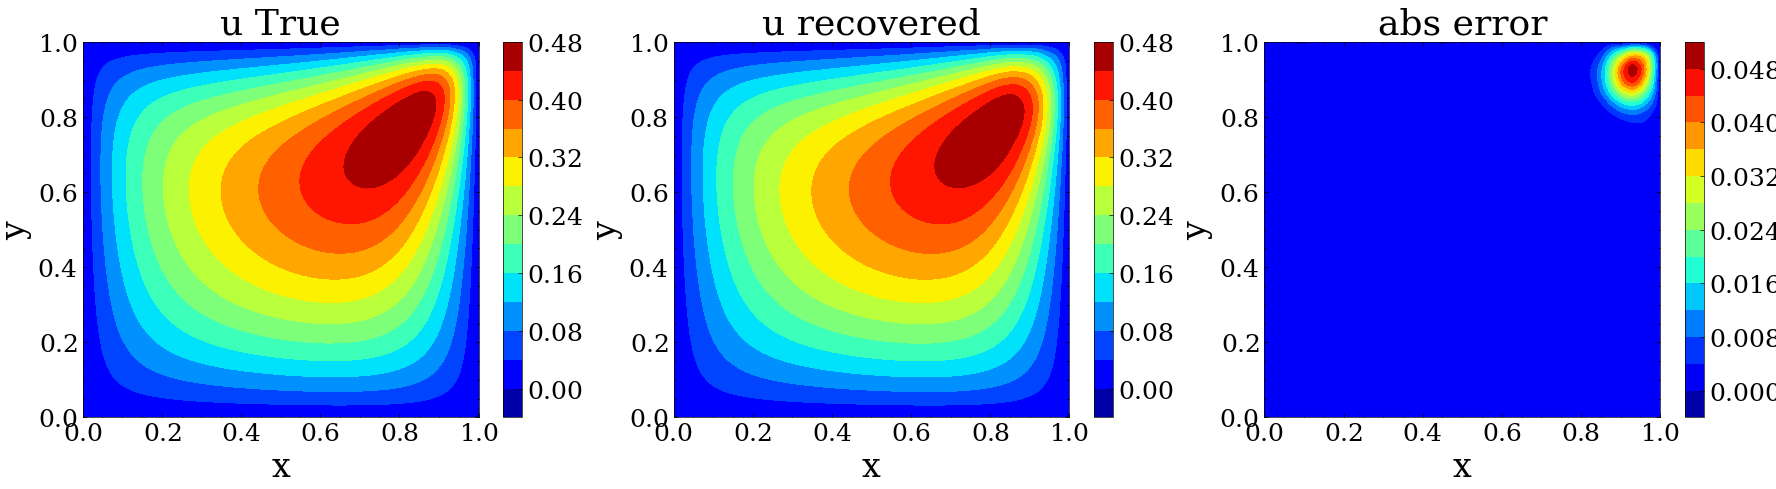

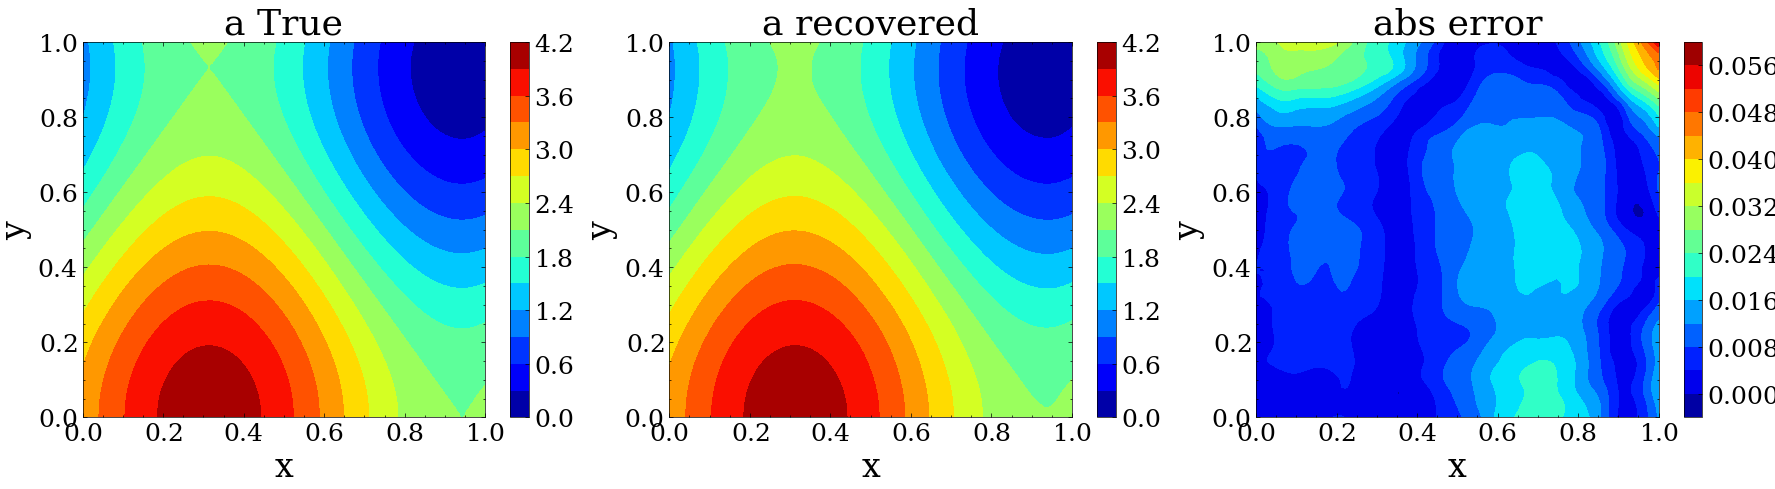

In [4]:
################################## load trained model
model_trained_inv = solver.loadModel(path=f'saved_models/DGNO_inverse_{noise_level}/', 
                                     name=f'model_dgno_final')
################################## make prediction
with torch.no_grad():
    x_coe = gridx.repeat(a_true.shape[0], 1, 1)
    x_var = x.to(device)
    beta_pred = model_trained_inv['beta_inv'](torch.ones((1,1,1)).to(device))
    beta_true = model_trained['enc'](a_true.to(device))
    #
    u_pred = model_trained['u'](x_var, beta_pred)
    u_pred = mollifer()(u_pred, x_var).detach().cpu()
    #
    a_pred_fwd = model_trained['a'](x_var, beta_true).detach().cpu()
    a_pred = model_trained['a'](x_var, beta_pred).detach().cpu().unsqueeze(-1)
print('The test l2 error (u avg):', solver.getError(u_pred, u_true))
print('The test l2 error (a avg):', solver.getError(a_pred, a_true))
# # ########################################
from Utils.PlotFigure import Plot
Plot.show_2d_list(gridx, [u_true, u_pred, abs(u_pred-u_true)],
                  ['u True', 'u recovered', 'abs error'], lb=0.)
Plot.show_2d_list(gridx, [a_true, a_pred, abs(a_pred-a_true)], 
                  ['a True', 'a recovered', 'abs error'], lb=0.)